#Preamble

Glaciated:  
BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER (08ME023)  
HOMATHKO RIVER AT THE MOUTH (08GD004)  
NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT (05DA009)  

Snowy, then depleted:  
CHILLIWACK RIVER ABOVE SLESSE CREEK (08MH103)   
FINLAY RIVER ABOVE AKIE RIVER (07EA005)  
SKEENA RIVER AT USK (08EF001)  

Snowy, but already (or mostly) depleted:  
ELK RIVER AT FERNIE (08NK002)  
SALMO RIVER NEAR SALMO (08NE074)  
OYSTER RIVER BELOW WOODHUS CREEK (08HD011)  

Alberta -- Similar place, different response:  
ATHABASCA RIVER NEAR JASPER  
MIETTE RIVER NEAR JASPER  

Alberta -- Same river, different place:  
BOW RIVER AT LAKE LOUISE  
BOW RIVER AT BANFF  


In [20]:
dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_data_realtime = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/temporary' #where to store data
!pip install geopandas

In [2]:
#import required libraries

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pickle

from datetime import datetime, date, timedelta
from google.colab import drive

In [3]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

# Flow data

In [145]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
stationIDs_all = flowDict['stationID']
stationNames = flowDict['stationName']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']

F = flowDict['all_flow_NF'] 

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [161]:
stationIDs = [
              '08ME023',
              '08GD004',
              '05DA009',
              '08MH103',
              '07EA005',
              '08EF001',
              '08NK002',
              '08NE074',
              '08HD011'
]

stationInds = np.array([int(np.argwhere(stationIDs_all == stationID).squeeze()) for stationID in stationIDs])
classes = [0,0,0,1,1,1,2,2,2]

filenames = [stationID + '_QR_Oct-11-2021.csv' for stationID in stationIDs]

date_inds = np.argwhere(
    (flowMonths == 5) |
    (flowMonths == 6) |
    (flowMonths == 7) |
    (flowMonths == 8) |
    (flowMonths == 9)
).squeeze()

date_inds = np.argwhere(
    (flowMonths == 5) |
    (flowMonths == 6) |
    (flowMonths == 7) |
    (flowMonths == 8)
).squeeze()

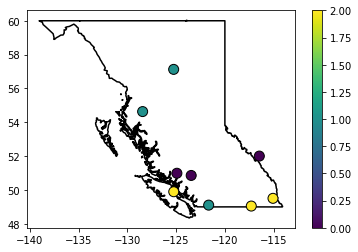

In [163]:
fig, ax = plt.subplots()
plot_prov_ax(prov = ['BC'], ax = ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = classes, zOrder = 5, s = 100, edgecolor = 'k', linewidth = 1)
plt.colorbar(s)

In [167]:
#calculate historical flows

Ndays = 153
Ndays = 123
Nstations = len(stationInds)

flow_mean = np.zeros((Nstations, Ndays))
flow_median = np.zeros((Nstations, Ndays))
flow_std = np.zeros((Nstations, Ndays))

for kk, station in enumerate(stationInds):

  flow_hist = F[station,:]
  flow_mat = flow_hist[date_inds].reshape(-1,Ndays)
  flow_mean[kk,:] = np.mean(flow_mat, axis = 0)
  flow_median[kk,:] = np.median(flow_mat, axis = 0)
  flow_std[kk,:] = np.std(flow_mat, axis = 0)

In [168]:
#calculate 2021 flows

flow_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  df = pd.read_csv(dir_data_realtime + '/' + filenames[station], header = 7)
  flow_realtime = df['Value (m3/s)']
  date_flow = [dd[:10] for dd in df[df.columns[0]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_flow) if ee == ds])
    flow_daily[station,day] = np.nanmean(flow_realtime[inds])

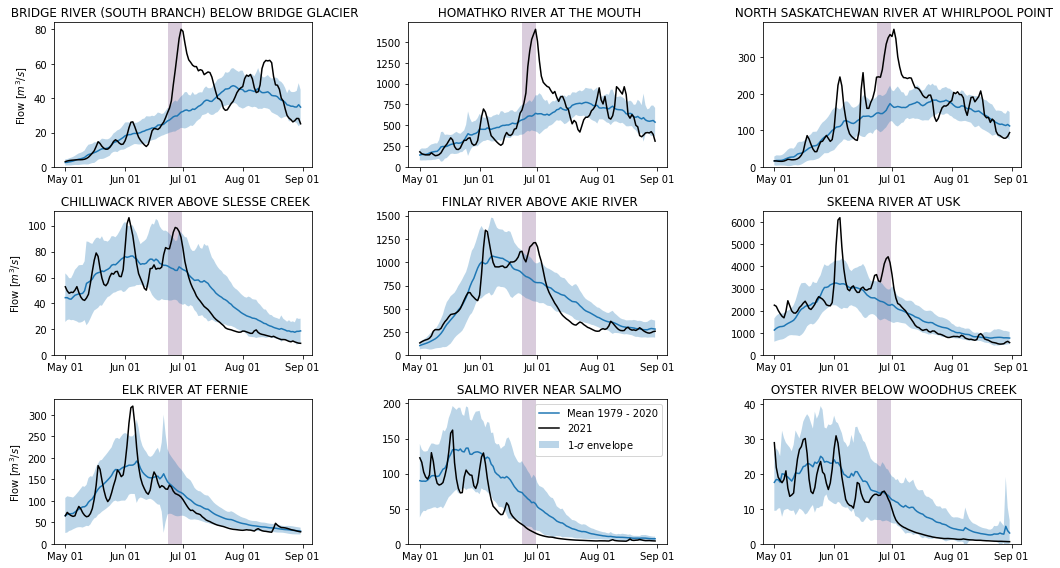

In [179]:
#visualize

saveIt = 1

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_mean[station,:] + flow_std[station,:]
  y2 = flow_mean[station,:] - flow_std[station,:]

  bottom = 0
  top = np.max([flow_daily[station,:], y1])*1.05

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, flow_mean[station,:], label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  ax.set_title(stationNames[stationInds[station]])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

# Temp data

In [180]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_era.csv')
date_temp = df['date']

,Unnamed: 0,date,08ME023,08GD004,05DA009,08MH103,07EA005,08EF001,08NK002,08NE074,08HD011
0,1,2021-05-01,273.297913,275.795471,273.579651,280.445374,276.385803,276.210999,280.858948,282.107971,283.649475
1,2,2021-05-02,272.120300,275.267273,270.010925,278.815613,275.424011,277.431335,276.583191,279.067566,281.774597
2,3,2021-05-03,273.274658,276.885010,271.325439,280.072021,276.082275,277.119385,275.737549,279.379150,283.140869
3,4,2021-05-04,272.117615,275.788025,271.512146,279.320251,275.441345,277.015564,276.066345,278.475525,282.034607
4,5,2021-05-05,272.564514,275.547424,271.621155,281.129944,275.225647,276.208557,277.890686,280.578186,282.300842


In [185]:
#calculate 2021 temp

temp_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  temp_realtime = df[stationIDs[station]]
  date_temp = [dd[:10] for dd in df[df.columns[1]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_temp) if ee == ds])
    temp_daily[station,day] = np.nanmean(temp_realtime[inds])

In [203]:
len(df.columns[2:])

9

In [246]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_eraland.csv')
temp_date = df['date']
temp_months = np.array([int(dd[5:7]) for dd in temp_date])[:-212]
T = df[df.columns[2:]].values
T = T[:-121,:]

date_inds = np.argwhere(
    (temp_months == 5) |
    (temp_months == 6) |
    (temp_months == 7) |
    (temp_months == 8)
).squeeze()

In [247]:
#calculate historical flows

Ndays = 153
Ndays = 123
Nstations = len(stationInds)

temp_mean = np.zeros((Nstations, Ndays))
temp_median = np.zeros((Nstations, Ndays))
temp_std = np.zeros((Nstations, Ndays))

for kk, station in enumerate(stationInds):

  temp_hist = T[:,kk]
  temp_mat = temp_hist[date_inds].reshape(-1,Ndays)
  temp_mean[kk,:] = np.mean(temp_mat, axis = 0)
  temp_median[kk,:] = np.median(temp_mat, axis = 0)
  temp_std[kk,:] = np.std(temp_mat, axis = 0)

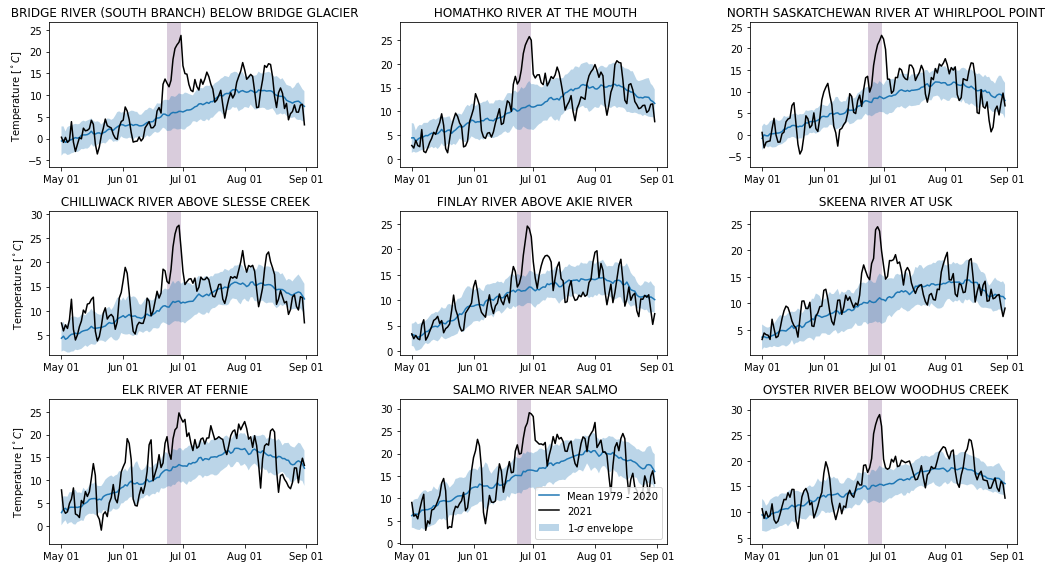

In [258]:
#visualize

saveIt = 1

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = temp_mean[station,:] + temp_std[station,:] - 273
  y2 = temp_mean[station,:] - temp_std[station,:] - 273

  bottom = np.min([temp_daily[station,:] - 273, y1]) - 3 
  top = np.max([temp_daily[station,:] - 273, y1]) + 3 

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, temp_mean[station,:] - 273, label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, temp_daily[station,:] - 273, 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Temperature [$^\circ C$]')

  ax.set_title(stationNames[stationInds[station]])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_temps.png', dpi = 300, bbox_inches = 'tight')